In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
import time
from time import process_time
from scipy.optimize import *
from scipy.optimize import minimize_scalar

# !pip install pyMCFSimplex 
from pyMCFSimplex import *

### 1. Generazione delle istanze del problema
La prima funzione *genera_Q(alpha, u, q, dimensione, p)* serve per generare i costi quadratici 
che si aggiungono ai costi lineari dell'istanza di MCF;
la stategia di generazione prevede di generare randomicamente (uniformemente) costi Qij "piccoli" o "grandi" rispetto ai costi lineari, 
come specificato dal parametro *alpha*. 

Permette inoltre di definire - tramite il parametro *p* - la proporzione di archi che hanno costo quadratico Qij nullo, 
abilitando la definizione e l'analisi anche di matrici semi-definite positive (0 &le; p &le; 1). 

La seconda funzione *leggi_file_dimacs(nome_file)* serve per estrarre le seguenti quantità: 
 - u, b, q
 - numero nodi
 - numero archi 

dal relativo file *.dmx*, generato [qui](https://commalab.di.unipi.it/datasets/mcf/). 

In [3]:
def genera_Q(alpha, u, q, dimensione, p):
    
    Q_diag = []

    for i in range(dimensione):
        Q_i = abs(random.uniform((-q[i] / u[i] * alpha), (q[i] / u[i] * alpha))) # generazione randomica 
        Q_diag.append(Q_i)

    Q = np.zeros((dimensione, dimensione))
    np.fill_diagonal(Q, Q_diag) # creazione matrice 

    num_entrate_zero = int(p * dimensione) 
    indici_zeri = np.random.choice(dimensione, num_entrate_zero, replace=False) # trova p*dimensione indici dei costi quadratici da mettere a zero 

    for idx in indici_zeri:
        Q[idx, idx] = 0
        # Q_diag[idx] = 0

    return Q #, Q_diag


def leggi_file_dimacs(nome_file):
    numero_nodi = 0
    numero_archi = 0
    u = []
    b = []
    q = []
    from_= []
    to_= []
    edges = []

    with open(nome_file, 'r') as file:
        for line in file:
            parts = line.split()
            if len(parts) > 0:
                if parts[0] == 'p':  # parts[0] è il primo carattere di ogni riga - nel formato standard DIMACS può essere c, p, n, a
                    # legge il numero di nodi e archi dal problema
                    numero_nodi = int(parts[2])
                    numero_archi = int(parts[3])
                    # inizializza il vettore di supply con zeri
                    b = [0] * numero_nodi
                elif parts[0] == 'n':
                    # legge i valori di supply per i nodi
                    nodo_id = int(parts[1])
                    supply = int(parts[2])
                    # assegna il valore di supply al nodo corrispondente
                    b[nodo_id - 1] = supply
                elif parts[0] == 'a':
                    # leggi l'arco e il suo cotso
                    from_node = int(parts[1])
                    to_node = int(parts[2])
                    max_capacity = int(parts[4])
                    costo = int(parts[5])  # leggiamo costo corretto
                    from_.append(from_node)
                    to_.append(to_node)
                    u.append(max_capacity)
                    q.append(costo)
                    edges.append((from_node , to_node ))

    return numero_nodi, numero_archi, np.array(u), b, np.array(q), edges,from_, to_

### 2. Implementazione dell'algoritmo

In [4]:
# Questa funzione crea un nuovo file .dmx in cui i valori delle righe che iniziano con 'a' (definizione archi)
# vengono sostituiti con i valori presenti nel vettore gradient. L'obiettivo è modificare il file di input 
# (input_file) in modo da utilizzare al posto dei costi lineari del file originale, il gradiente 
# (vogliamo risolvere il sottoproblema lineare, aka l'approssimazione lineare del problema Taylor 1st ordine).   

def modify_file_with_gradient(input_file, output_file, gradient):
    with open(input_file, 'r') as file:
        lines = file.readlines()

    # inizalizzazione dell'indice per il vettore gradient
    gradient_index = 0

    # modifica delle righe che iniziano con 'a'
    for i in range(len(lines)):
        if lines[i].startswith('a'):
            words = lines[i].split()
            words[-1] = str(gradient[gradient_index])
            gradient_index += 1
            lines[i] = ' '.join(words)

    # creazione nuovo file
    with open(output_file, 'w') as file:
        file.writelines(lines)

In [5]:
# questo codice serve per calcolare lo step size trovando alpha che minimizzi f (xk + α(dk − xk))
# rispettando il vincolo 0 ≤ α ≤ 1. dove f è la nostra funzione di costo. 

# definizione della funzione quadratica - la nostra f iniziale x^TQx + q
def quadratic_function(alpha, xk, dk, Q, q):

    x_alpha = [x + alpha * (d - x) for x, d in zip(xk, dk)] 
    x_alpha = np.array(x_alpha) 

    # calcolo il valore della funzione obiettivo
    return x_alpha.T @ Q @ x_alpha + q @ x_alpha


def find_optimal_alpha(xk, dk, Q, q): # exact line search
   
    objective_function = lambda alpha: quadratic_function(alpha, xk, dk, Q, q) # nostra funzione obiettivo che dipende da alpha 
    result = minimize_scalar(objective_function, bounds=(0, 1), method = 'bounded') # soluzione del problema di minimo con vincolo su alpha che deve stare tra 0 e 1 

    return result.x


In [6]:
# MCF solver intern - do not change
def showModuleFunctionality(mcf):
    vettore_soluzione = {}  
    nmx = mcf.MCFnmax()
    mmx = mcf.MCFmmax()
    pn = mcf.MCFnmax()
    pm = mcf.MCFmmax()

    pU = []
    caps = new_darray(mmx)
    mcf.MCFUCaps(caps)
    for i in range(0, mmx):
        pU.append(darray_get(caps, i))

    pC = []
    costs = new_darray(mmx)
    mcf.MCFCosts(costs)
    for i in range(0, mmx):
        pC.append(darray_get(costs, i))

    pDfct = []
    supply = new_darray(nmx)
    mcf.MCFDfcts(supply)
    for i in range(0, nmx):
        pDfct.append(darray_get(supply, i))

    pSn = []
    pEn = []
    startNodes = new_uiarray(mmx)
    endNodes = new_uiarray(mmx)
    mcf.MCFArcs(startNodes, endNodes)
    for i in range(0, mmx):
        pSn.append(uiarray_get(startNodes, i) + 1)
        pEn.append(uiarray_get(endNodes, i) + 1)

    #print("arc flow")
    length = mcf.MCFm()
    flow = new_darray(length)
    length = mcf.MCFn()
    nms = new_uiarray(length)
    mcf.MCFGetX(flow, nms)

   

    for i in range(0, length):
       # print("flow", darray_get(flow, i), "arc", uiarray_get(nms, i))
        vettore_soluzione[uiarray_get(nms, i)] = darray_get(flow, i)

    return vettore_soluzione  # restituisce il vettore_soluzione alla fine della funzione

In [7]:
def visualize(k, f_val, alpha, prodotto_scalare, k_granularity, tempo, end, found_optimal): 

    # la funzione stampa un summary delle seguenti quantità ad ogni iterazione (oppure ogni 'k_granularity' iterazioni) :
    # - iterazione corrente
    # - step size, 
    # - optimal solution, 
    # - prodotto scalare 

    # alla fine dell'esecuzione verrà mostrato :
    # - prodotto scalare finale,
    # - step size finale
    # - numero totale di iterazioni
    # - tempo di esecuzione totale 
    
    if end:
        print("_"*110)
        print("STOP: ")
        if found_optimal:
            print('Found optimal solution!')
        print('Final scalar product: {:>10.6f}  Final step size: {:>10.8f}  Total number iterations: {:>4}'.format(prodotto_scalare, alpha, k))
        print('Total running time: {:>10.2f} seconds'.format(tempo))    
        
    if  k % k_granularity == 0:
        print('Iteration: {:>4}   Step size: {:>10.8f}   Valore di f in x_k: {:>10.6f}   Scalar product grad, d: {:>10.2f} '.format(k, alpha, f_val, prodotto_scalare))
    return

In [8]:
class ProblemUnfeasibleError(Exception):
    pass

#### 2a. Algoritmo FW TRADIZIONALE

Step: 

0. Inizializzazione di x<sub>0</sub> con generazione casuale soggetta al vincolo 0 &le; x<sub>0</sub> &le; u
1. Calcolo del gradiente, risoluzione del sottoproblema lineare usando il solver pyMCFSimplex (x̄), determinazione della direzione
2. Determinazione dello step size &alpha;
3. Aggiornamento della posizione e check terminazione sul prodotto scalare (<grad, d>)

In [9]:
def algoritmo_tradizionale(nome_file, epsilon, max_iter, Q, q, u, numero_archi, tau,x_0, step_size_ottimo=True, visualize_res=True):
    
    k = 0 
    alpha = 1 
    prodotto_scalare = float("inf")
    start_time = time.time()
    tempo_tot = 0
    end = False
    found_optimal = False
    gap = []
    tempi_per_it = [0]
    f_values = []
    


    # STEP 0 : inizializzazione di x_0
    #seed = 42
    #np.random.seed(seed)
    #x_old = []

    #for u_i in u:
     #   x_i = random.randint(0, u_i)
      #  x_old.append(x_i)
    
    x_old = x_0.copy()
    while  (abs(prodotto_scalare)>= epsilon and k < max_iter):

        start_it = process_time()

        f_x_current = np.dot(np.dot(x_old, Q), x_old) + np.dot(q, x_old)
        f_values.append(f_x_current)

        # STEP 1 : calcolo gradiente
        gradient = (2 * np.dot(Q, x_old)) + q
        gradient = gradient.tolist()
        modify_file_with_gradient(nome_file, 'output.dmx', gradient)

        # risoluzione del problema lineare (ricerca di argmin) con MCF solver
        FILENAME = 'output.dmx'
        f = open(FILENAME,'r')
        inputStr = f.read()
        f.close()
        mcf = MCFSimplex()
        mcf.LoadDMX(inputStr)
        mcf.SolveMCF()
        if mcf.MCFGetStatus() == 0:
            soluzione_ottima = mcf.MCFGetFO()
            if visualize_res:
                visualize(k, f_values[-1] , alpha, prodotto_scalare, k_granularity = 2, tempo = tempo_tot, end = end, found_optimal = found_optimal)

        else:
            raise ProblemUnfeasibleError("The problem is unfeasible.")
         
        vettore_soluzione = showModuleFunctionality(mcf)
     
        sol_x = [0] * numero_archi
        for key in vettore_soluzione:
            if key <= 1000:
                sol_x[key-1] = vettore_soluzione[key]

        # calcolo delle x_bar e determinazione della direzione di ricerca
        x_bar = np.array(sol_x.copy())

        # TRUST REGION STABILIZATION
        u = np.array(u)
        if tau > 0: 
            lb = x_bar - tau * u # calcolo lower bound e upper bound della trust region 
            ub = x_bar + tau * u
            x_bar = np.maximum(lb, np.minimum(x_bar, ub)) 

        d = [a - b for a, b in zip(x_bar, x_old)] # direzione


        # STEP 2 : determinazione alpha, step size 

        if step_size_ottimo:
            alpha = find_optimal_alpha(x_bar, d, Q, q)
        else:
            alpha = 2 / (2+k)

        # STEP 3 : aggiornamento della posizione
        x_new = []

        for i in range(len(x_old)):
            x_i_new = x_old[i] + alpha * d[i]
            x_new.append(x_i_new)

        # check terminazione 
        gradient_per_check = (2 * np.dot(Q, x_new) ) + q
        prodotto_scalare = np.dot(gradient_per_check, d)


        gap.append(prodotto_scalare)

        # aggiornamento poszione e incremento numero di iterazioni
        x_old = x_new
        k += 1

        end_it = process_time()
        tempi_per_it.append(tempi_per_it[k-1] + end_it - start_it)

        if not(abs(prodotto_scalare)>= epsilon and k < max_iter):
            end = True
            if k < max_iter:
                found_optimal = True
            end_time = time.time()
            tempo_tot = end_time - start_time
            if visualize_res: 
                visualize(k, f_values[-1], alpha, prodotto_scalare, k_granularity = 2, tempo = tempo_tot, end = end, found_optimal = found_optimal)
    
    # f_values.append(np.dot(np.dot(x_new, Q), x_new) + np.dot(q, x_new))
    
    return gap, f_values, k, tempo_tot, tempi_per_it, x_old, soluzione_ottima, found_optimal

#### 2b. Algoritmo FW variante - AWAY STEP

In [10]:
# away vertex
def away_step(grad, S):
    costs = {}
    
    for k,v in S.items():
        cost = np.dot(k,grad)
        costs[cost] = [k,v]
    vertex, alpha = costs[max(costs.keys())]  
    return vertex, alpha

# aggiornare active set come pseudocodice 
def update_S(S,gamma, Away, vertex):
    
    S = S.copy()
    vertex = tuple(vertex)
    
    if not Away:
        if vertex not in S.keys():
            S[vertex] = gamma
        else:
            S[vertex] *= (1-gamma)
            S[vertex] += gamma
            
        for k in S.keys():
            if k != vertex:
                S[k] *= (1-gamma)
    else:
        for k in S.keys():
            if k != vertex:
                S[k] *= (1+gamma)
            else:
                S[k] *= (1+gamma)
                S[k] -= gamma
    return {k:v for k,v in S.items() if np.round(v,3) > 0}


In [11]:
def line_search_afw(x, d, gamma_max,func):
    
    def fun(gamma):
        ls = x + gamma*d
        return func(ls)

    res = minimize_scalar(fun, bounds=(0, gamma_max), method='bounded')

    gamma = res.x
    ls = x + gamma*d        
    return ls, gamma

In [12]:
#AFW Algorithm
  
def AFW(nome_file, epsilon, max_iter, Q, q, numero_archi,func, k_granularity, x_0, visualize_res=True):
    
    k = 0    
    gamma = 1
    start_time = time.time()
    tempo_tot = 0
    prodotto_scalare = -float("inf")
    end = False
    found_optimal = False
    f_values = []
    tempi_per_it = [0]
    gap = []
    
    x_old=np.array(x_0)

  
    S = {tuple(x_old): 1} # active set inizializzazione

    while abs(prodotto_scalare)>= epsilon and k < max_iter: # stopping criteria

        start_it = process_time()

        f_x_current = np.dot(np.dot(x_old, Q), x_old) + np.dot(q, x_old)
        f_values.append(f_x_current)

        # STEP 1 : calcolo gradiente
        gradient = (2 * np.dot(Q, x_old)) + q
        modify_file_with_gradient(nome_file, 'output3.dmx', gradient)

        # risoluzione del problema lineare (ricerca di argmin) con MCF solver
        FILENAME = 'output3.dmx'
        f = open(FILENAME,'r')
        inputStr = f.read()
        f.close()
        mcf = MCFSimplex()
        mcf.LoadDMX(inputStr)
        mcf.SolveMCF()
        if mcf.MCFGetStatus() == 0:
            # soluzione_ottima = mcf.MCFGetFO()
            if visualize_res:
                visualize(k, f_values[-1] , gamma, prodotto_scalare, k_granularity = k_granularity, tempo = tempo_tot, end = end, found_optimal = found_optimal)

        else:
            print( "Problem unfeasible!")

        vettore_soluzione = showModuleFunctionality(mcf)
     
        sol_x = [0] * numero_archi
        for key in vettore_soluzione:
            if key <= 1000:
                sol_x[key-1] = vettore_soluzione[key]

        # calcolo delle x_bar e determinazione della direzione di ricerca
        v = sol_x.copy()
    
        d_FW = v - x_old
        
        # calcolo away vertex e direzione d_A 
        a, alpha_a = away_step(gradient, S)
        d_A = x_old - a

        # Check se FW gap è maggiore dell'away gap --> per capire quale passo usare 
        if np.dot(-gradient, d_FW) >= np.dot(-gradient, d_A):
            # scegliamo FW direction
            d = d_FW
            vertex = v
            gamma_max = 1
            Away = False
        else:
            # scegliamo Away direction
            d = d_A
            vertex = a
            # ATTENZIONE ZERO DIVISION ERROR QUI 
            gamma_max = alpha_a/(1-alpha_a)
            # print('alpha AFW:', alpha_a)
            Away = True

        # ricerca di x_new e gamma usando line search 
        prodotto_scalare = np.dot(gradient, d)
        x_new, gamma = line_search_afw(x_old,d, gamma_max, func)

        # aggiornamento active set
        S = update_S(S,gamma, Away, vertex)


        #gradient_per_check = (2 * np.dot(Q, x_new) ) + q
        #prodotto_scalare = np.dot(gradient_per_check, d)

        gap.append(prodotto_scalare)


        x_old = x_new
        k+=1

        end_it = process_time()
        tempi_per_it.append(tempi_per_it[k-1] + end_it - start_it)

        if not(abs(prodotto_scalare)>= epsilon and k < max_iter):
            end = True
            if k < max_iter:
                found_optimal = True
            end_time = time.time()
            tempo_tot = end_time - start_time
            if visualize_res:
                visualize(k, f_values[-1], gamma, prodotto_scalare, k_granularity= k_granularity, tempo = tempo_tot, end = end, found_optimal = found_optimal)
    

    return gap, f_values, k, tempo_tot, tempi_per_it, x_old, found_optimal


### PROVE ALGORITMI 

In [ ]:
## PROVA FW TRADIZIONALE

nome_file_dmx = '1000/netgen-1000-1-2-b-a-s.dmx'
_, numero_archi, u, _, q, _, _ , _ = leggi_file_dimacs(nome_file_dmx)
Q = genera_Q(1, u, q, numero_archi, 0.3)
# Q = genera_Q(100, u, q, numero_archi, 0.0)
seed = 43
np.random.seed(seed)
x_0 = []
for u_i in u:
    x_i = random.randint(0, u_i)
    x_0.append(x_i)

gap, valori_f, k_totale, tempo_totale, tempi_per_it, x, sol_ottima, found_optimal = algoritmo_tradizionale(nome_file_dmx, epsilon = 0.0001, max_iter = 1000, Q = Q, q = q, u = u, numero_archi = numero_archi, tau = 0.01, step_size_ottimo = True, x_0 = x_0)


In [ ]:
## PROVA DI FW AWAY 

#seed = 42
#np.random.seed(seed)
# x_0 = []

# nome_file_dmx = '1000/netgen-1000-1-5-a-b-ns.dmx'

func = lambda x: np.dot(x, np.dot(Q, x))+np.dot(q,x)
# _, numero_archi, u, _, q, _,_, _ = leggi_file_dimacs(nome_file_dmx)
# Q = genera_Q(100, u, q, numero_archi, 0.2)
# for u_i in u:
 #   x_i = random.randint(0, u_i)
  #  x_0.append(x_i)

gap_afw, f_values_afw, k_afw, tempo_tot_afw, tempi_per_it_afw, x_afw, found_optimal_afw = AFW(nome_file_dmx, epsilon = 0.001, max_iter = 1000, Q = Q, q = q, numero_archi = numero_archi, func=func, k_granularity=1, x_0 = x_0)

### 3. Funzioni per PLOT


In [13]:
# queste due funzioni plottano il FW (dual) gap e il primal gap 

def plot_dual_gap(gap_fw, gap_afw, axes):
    
    gap_fw = np.abs(gap_fw)
    gap_afw = np.abs(gap_afw)
    iterazioni_fw = list(range(1, len(gap_fw) + 1))
    iterazioni_afw = list(range(1, len(gap_afw) + 1))

    plt.style.use('ggplot')
    # plt.figure(figsize=(8, 6))
    axes[0].plot(iterazioni_fw, gap_fw, color = 'lightseagreen', label = 'FW')
    axes[0].plot(iterazioni_afw, gap_afw, color = 'darkred', label = 'AFW')
    axes[0].set_xlabel('Iterazioni (k)', fontsize= 10)
    axes[0].set_yscale('log')
    axes[0].set_ylabel(r'dual gap = $|<grad(f), d>|$', fontsize=10)
    
    axes[0].set_title('Andamento del Dual Gap (aka FW Gap) in funzione di k', fontsize=11)
    axes[0].legend(fontsize='small', loc='upper right')
    plt.grid(True)

    # plt.show()


def plot_primal_gap(f_values_fw, xstar_fw, found_optimal_fw, f_values_afw, xstar_afw, found_optimal_afw, axes):   
    # f(x) - f(x*)

    # check iniziale:  
    # se l'algoritmo ha trovato x ottima (ie il criterio di stop verificato è quello sul gap, non su max iter)
    # allora ha senso calcolare f(x*)
    if found_optimal_fw and found_optimal_afw:

        xstar_fw = np.array(xstar_fw)
        xstar_afw = np.array(xstar_afw)
        fxstar_fw = xstar_fw.T @ Q @ xstar_fw + q @ xstar_fw
        fxstar_afw = xstar_afw.T @ Q @ xstar_afw + q @ xstar_afw
        gap_fw = np.abs(f_values_fw - fxstar_fw)
        gap_afw = np.abs(f_values_afw - fxstar_afw)
        iterazioni_fw = list(range(1, len(f_values_fw) + 1))
        iterazioni_afw = list(range(1, len(f_values_afw) + 1))
        
        plt.style.use('ggplot')
        #plt.figure(figsize=(8, 6))
        axes[1].plot(iterazioni_fw, gap_fw, color = 'lightseagreen', label = 'FW')
        axes[1].plot(iterazioni_afw, gap_afw, color = 'darkred', label = 'AFW')
        axes[1].set_xlabel('Iterazioni (k)', fontsize=10)
        axes[1].set_yscale('log')
        axes[1].set_ylabel(r'primal gap = $|f(x) - f(x*)|$', fontdict={'style': 'italic', 'fontsize':10})
        
        axes[1].set_title('Andamento del Primal Gap in funzione di k', fontsize=11)
        axes[1].legend(fontsize='small', loc='upper right')
        
        plt.grid(True)

        # plt.show()
        
    else: 
        ('primal gap non disponibile')

In [29]:
def plot_dual_gap_bis(gap_fw, gap_afw, p, alpha): # senza axes 
    
    gap_fw = np.abs(gap_fw)
    gap_afw = np.abs(gap_afw)
    iterazioni_fw = list(range(1, len(gap_fw) + 1))
    iterazioni_afw = list(range(1, len(gap_afw) + 1))

    plt.style.use('ggplot')
    plt.figure(figsize=(8, 6))
    plt.plot(iterazioni_fw, gap_fw, color = 'lightseagreen', label = 'FW')
    plt.plot(iterazioni_afw, gap_afw, color = 'darkred', label = 'AFW')
    # axes[0].axhline(y = 0.0001, color='red', linestyle='--', label='Valore stop epsilon')
    plt.xlabel('Iterazioni (k)', fontsize= 12)
    plt.yscale('log')
    plt.ylabel(r'dual gap = $|<grad(f), d>|$', fontsize=12)
    plt.xticks(iterazioni_fw)
    plt.title('Andamento del FW Gap in funzione di k - p={}, alpha={}'.format(p, alpha), fontsize=14)
    plt.legend(fontsize='small', loc='upper right')
    plt.grid(True)

    plt.show()


In [15]:
# l'obiettivo di questa funzione è mostrare che effettivamente il FW gap (dual gap) costituisce un upper bound al primal gap


def plot_dual_and_primal_gap(f_values, dual_gap, xstar):
    dual_gap = np.abs(dual_gap)
    iterazioni = list(range(1, len(dual_gap) + 1))
    
    plt.style.use('ggplot')
    plt.figure(figsize=(8, 6))
    
    plt.plot(iterazioni, dual_gap, color='lightseagreen', label='Dual Gap (aka FW Gap)')
    
    xstar = np.array(xstar)
    fxstar = xstar.T @ Q @ xstar + q @ xstar
    primal_gap = np.abs(f_values - fxstar)
    plt.plot(iterazioni, primal_gap, color='dodgerblue', label='Primal Gap')
    
    plt.xlabel('Iterazioni (k)')
    plt.ylabel('Gap', fontdict={'style': 'italic'})
    
    plt.title('Andamento del Dual Gap e del Primal Gap in funzione di k - 1000 nodi', fontsize=12)
    plt.legend()
    plt.grid(True)

    plt.show()


In [19]:
# questa funzione plotta un grafico di convergenza: 
# viene mostrato l'andamento della convergenza teorica e reale per FW tradizionale
# conv teorica  :  f(x)-f(x^*) <=  2LD^2 / (k+3)
def plot_convergenza(f_values, k_tot, Q, nome_file_dmx):
    
    _, _, u, _, _, _, _ , _ = leggi_file_dimacs(nome_file_dmx)
    Q_diag = np.diag(Q)

    # l'autovalore massimo di Q è la costante di convergenza L 
    L = np.max(Q_diag)
    # il diametro dello spazio D è la norma del vettore u 
    D = np.linalg.norm(u) 

    k_values = []  # valori di k (iterazione)
    convergence_values = []  # valori di convergenza teorica

    # simulo i dati teorici (convergenza teorica)
    for k in range(1, k_tot + 1):
        k_values.append(k)
        convergence_values.append((2 * L * D**2) / (k + 3)) # formula converg teorica
    plt.style.use('ggplot')
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, convergence_values, label="Convergenza Teorica", linestyle='--', linewidth = 3)
    plt.plot(k_values, f_values, label="Convergenza Effettiva" , linestyle='-', linewidth = 3)
    # plt.yscale("log") 
    #plt.ylim(1e4, 1e9)
    plt.xlabel("Iterazione (k)", fontsize = 17)
    plt.ylabel(r'Valore di convergenza = $|f(x) - f(x*)|$', fontsize = 17)
    
    plt.legend()
    plt.title("Convergenza teorica vs effettiva", fontsize = 23)
    plt.grid(True)

    plt.show()

    return

### 4. Esperimenti

In [15]:
folder_path = r'C:\Users\Valeria\Documents\GitHub\Optimization\1000' # path assoluto della cartella 1000
esperimenti = []
file_names = os.listdir(folder_path)

for file_name in file_names:
    if file_name.endswith('.dmx'):
        file_path = os.path.join(folder_path, file_name)
        relative_path = os.path.relpath(file_path, os.getcwd())
        esperimenti.append(relative_path)

#### Plot preliminari

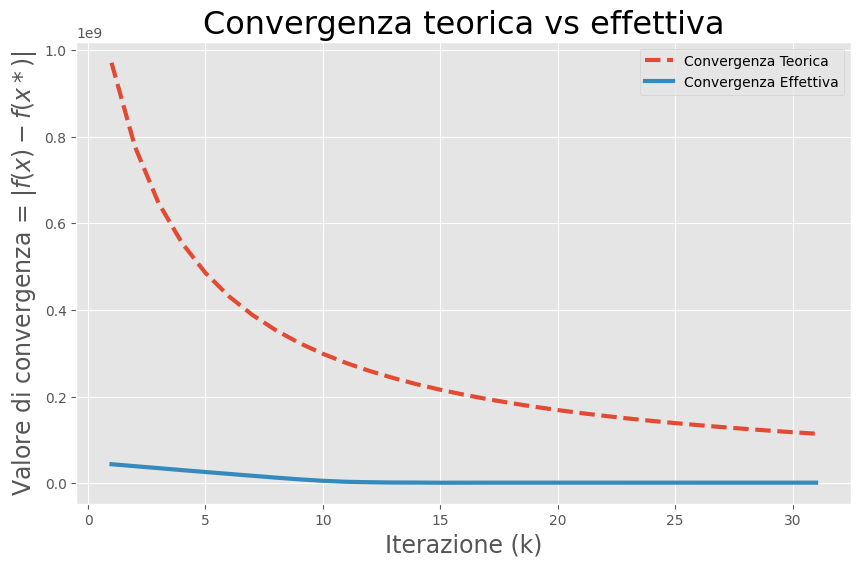

In [31]:
nome_file_dmx = '1000/netgen-1000-1-1-b-b-s.dmx'
_, numero_archi, u, _, q, _, _, _ = leggi_file_dimacs(nome_file_dmx)
x_0 = [random.randint(0, u_i) for u_i in u]
Q = genera_Q(100, u, q, numero_archi, 0.5)

gap, valori_f, k_totale, tempo_totale, tempi_per_it, x, sol_ottima, found_optimal = algoritmo_tradizionale(nome_file_dmx, epsilon = 0.0001, max_iter = 1000, 
                                                                                                           Q = Q, q = q, u = u, numero_archi = numero_archi, tau = 0.01, 
                                                                                                           step_size_ottimo = True, x_0 = x_0, visualize_res = False)
plot_convergenza(valori_f, k_totale, Q, nome_file_dmx)

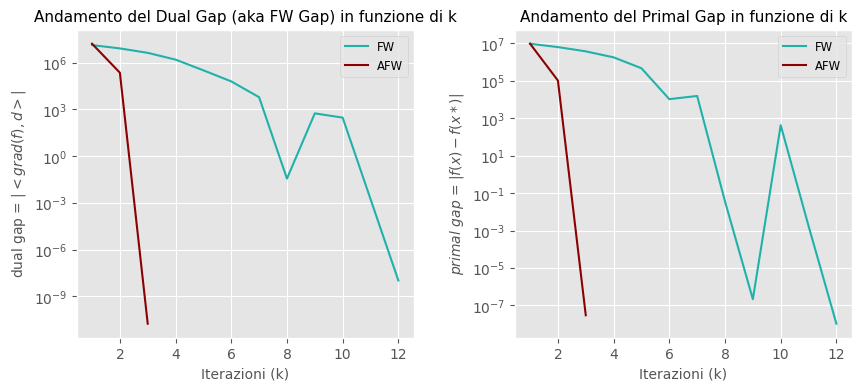

In [33]:
for nome_file_dmx in esperimenti[:10]:  # uso i primi file dmx
    
    _, numero_archi, u, _, q, _, _ , _ = leggi_file_dimacs(nome_file_dmx)
    Q = genera_Q(10, u, q, numero_archi, 0.3)
    func = lambda x: np.dot(x, np.dot(Q, x))+np.dot(q,x)

    np.random.seed(42)
    x_0 = []
    for u_i in u:
        x_i = random.randint(0, u_i)
        x_0.append(x_i)
    
    gap, valori_f, k_totale, tempo_totale, tempi_per_it, x, sol_ottima, found_optimal = algoritmo_tradizionale(nome_file_dmx, epsilon = 0.001, max_iter = 1000, Q = Q, q = q, u = u, numero_archi = numero_archi, tau = 0.01, step_size_ottimo = True, x_0 = x_0, visualize_res = False)
    gap_afw, f_values_afw, k_afw, tempo_tot_afw, tempi_per_it_afw, x_afw, found_optimal_afw = AFW(nome_file_dmx, epsilon = 0.001, max_iter = 1000, Q = Q, q = q, numero_archi = numero_archi, func=func, k_granularity=1, x_0 = x_0, visualize_res = False)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    plt.subplots_adjust(wspace=0.3)
    plot_primal_gap(valori_f, x, found_optimal,f_values_afw, x_afw, found_optimal_afw, axes)
    plot_dual_gap(gap, gap_afw, axes)

    # file_name_png = nome_file_dmx + '.png'
    # plt.savefig(file_name_png, dpi=300, bbox_inches='tight')

    plt.show()

#### Effetto della Trust Region Stabilization

In [24]:
taus = [0, 0.0001, 0.001, 0.01, 0.1, 0.5] # tau da provare

repetitions = 5
# repetitions = 1 

data = {'Tau': taus, 'Media_Iterazioni': [], 'Media_Tempi': [], 'Numero di volte in cui è stato trovato ottimo': []}

for tau in taus:

    iterazioni_per_tau = []
    tempi_per_tau = []
    ottimo = 0

    for nome_file_dmx in esperimenti[:100]:  
        
        # raccolgo risultati per file specifico
        iterazioni_per_file = []
        tempi_per_file = []
        ottimo_per_file = 0

        for _ in range(repetitions): 
            _, numero_archi, u, _, q, _, _, _ = leggi_file_dimacs(nome_file_dmx)
            Q = genera_Q(10, u, q, numero_archi, 0.3)
            func = lambda x: np.dot(x, np.dot(Q, x)) + np.dot(q, x)

            np.random.seed(42)
            x_0 = [random.randint(0, u_i) for u_i in u]

            try:
                gap, valori_f, k_totale, tempo_totale, tempi_per_it, x, sol_ottima, found_optimal = algoritmo_tradizionale(nome_file_dmx, epsilon=0.0001, max_iter=1000, Q=Q, q=q, u=u, numero_archi=numero_archi, tau=tau, step_size_ottimo=True, x_0=x_0, visualize_res=False)
            except ProblemUnfeasibleError as e: 
                break

            iterazioni_per_file.append(k_totale)
            tempi_per_file.append(tempo_totale)
            if found_optimal:
                ottimo_per_file += 1

        # media dei risultati per file
        try:
            media_iterazioni_file = sum(iterazioni_per_file) / len(iterazioni_per_file)
            media_tempi_file = sum(tempi_per_file) / len(tempi_per_file)
        except:
            media_iterazioni_file = 0
            media_tempi_file = 0
        
        iterazioni_per_tau.append(media_iterazioni_file)
        tempi_per_tau.append(media_tempi_file)
        ottimo += ottimo_per_file

    try:
        media_iterazioni = sum(iterazioni_per_tau) / len(iterazioni_per_tau)
        media_tempi = sum(tempi_per_tau) / len(tempi_per_tau)
    except: 
        media_iterazioni = 0
        media_tempi = 0

    data['Media_Iterazioni'].append(media_iterazioni)
    data['Media_Tempi'].append(media_tempi)
    data['Numero di volte in cui è stato trovato ottimo'].append(ottimo)

df = pd.DataFrame(data)
# df.to_csv('tabella_effetto_trust_region', index=False)

C:\Users\Valeria\AppData\Local\Temp\ipykernel_6676\3491097637.py:11: RuntimeWarning: overflow encountered in matmul
  return x_alpha.T @ Q @ x_alpha + q @ x_alpha
c:\Users\Valeria\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_optimize.py:2233: RuntimeWarning: invalid value encountered in double_scalars
  r = (xf - nfc) * (fx - ffulc)
c:\Users\Valeria\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_optimize.py:2234: RuntimeWarning: invalid value encountered in double_scalars
  q = (xf - fulc) * (fx - fnfc)


#### Effetto di p (percentuale di autovalori a 0 in Q) sul numero di iterazioni/tempi

In [16]:
nome_file_dmx = '1000/netgen-1000-1-1-b-b-s.dmx'

_, numero_archi, u, _, q, _, _, _ = leggi_file_dimacs(nome_file_dmx)
x_0 = [random.randint(0, u_i) for u_i in u]

repetitions = 10
iterazioni = []
tempi = []
ottimo = []

for p in np.linspace(0, 1, 11):

    iterazioni_per_p = []
    tempi_per_p = []
    ottimo_per_p = 0

    for _ in range(repetitions):
        Q = genera_Q(10, u, q, numero_archi, p)
        try:
            gap, valori_f, k_totale, tempo_totale, tempi_per_it, x, sol_ottima, found_optimal = algoritmo_tradizionale(
                nome_file_dmx, epsilon=0.0001, max_iter=1000, Q=Q, q=q, u=u, numero_archi=numero_archi, tau=0.01, step_size_ottimo=True, x_0=x_0, visualize_res=False)
        except ProblemUnfeasibleError as e:
            break

        iterazioni_per_p.append(k_totale)
        tempi_per_p.append(tempo_totale)

        if found_optimal:
            ottimo_per_p += 1

    try:
        media_iterazioni_p = sum(iterazioni_per_p) / len(iterazioni_per_p)
        media_tempi_p = sum(tempi_per_p) / len(tempi_per_p)
    except ZeroDivisionError:
        media_iterazioni_p = 0
        media_tempi_p = 0

    iterazioni.append(media_iterazioni_p)
    tempi.append(media_tempi_p)
    ottimo.append(ottimo_per_p)


C:\Users\Valeria\AppData\Local\Temp\ipykernel_14564\3491097637.py:11: RuntimeWarning: overflow encountered in matmul
  return x_alpha.T @ Q @ x_alpha + q @ x_alpha
c:\Users\Valeria\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_optimize.py:2233: RuntimeWarning: invalid value encountered in double_scalars
  r = (xf - nfc) * (fx - ffulc)
c:\Users\Valeria\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_optimize.py:2234: RuntimeWarning: invalid value encountered in double_scalars
  q = (xf - fulc) * (fx - fnfc)


In [17]:
# stesso esperimento - per AFW 

nome_file_dmx = '1000/netgen-1000-1-1-b-b-s.dmx'
_, numero_archi, u, _, q, _, _, _ = leggi_file_dimacs(nome_file_dmx)
x_0 = [random.randint(0, u_i) for u_i in u]
func = lambda x: np.dot(x, np.dot(Q, x)) + np.dot(q, x)

repetitions = 10
iterazioni_afw = []
tempi_afw = []
ottimo_afw = []

for p in np.linspace(0, 1, 11):

    iterazioni_per_p = []
    tempi_per_p = []
    ottimo_per_p = 0

    for _ in range(repetitions):
        Q = genera_Q(10, u, q, numero_archi, p)
        try:
            gap_afw, f_values_afw, k_afw, tempo_tot_afw, tempi_per_it_afw, x_afw, found_optimal_afw = AFW(nome_file_dmx, epsilon = 0.0001, max_iter = 1000, Q = Q, 
                                                                                                          q = q, numero_archi = numero_archi, func=func, k_granularity=1, x_0 = x_0, visualize_res = False)
        except ProblemUnfeasibleError as e:
            break

        iterazioni_per_p.append(k_afw)
        tempi_per_p.append(tempo_tot_afw)

        if found_optimal:
            ottimo_per_p += 1

    try:
        media_iterazioni_p = sum(iterazioni_per_p) / len(iterazioni_per_p)
        media_tempi_p = sum(tempi_per_p) / len(tempi_per_p)
    except ZeroDivisionError:
        media_iterazioni_p = 0
        media_tempi_p = 0

    iterazioni_afw.append(media_iterazioni_p)
    tempi_afw.append(media_tempi_p)
    ottimo_afw.append(ottimo_per_p)

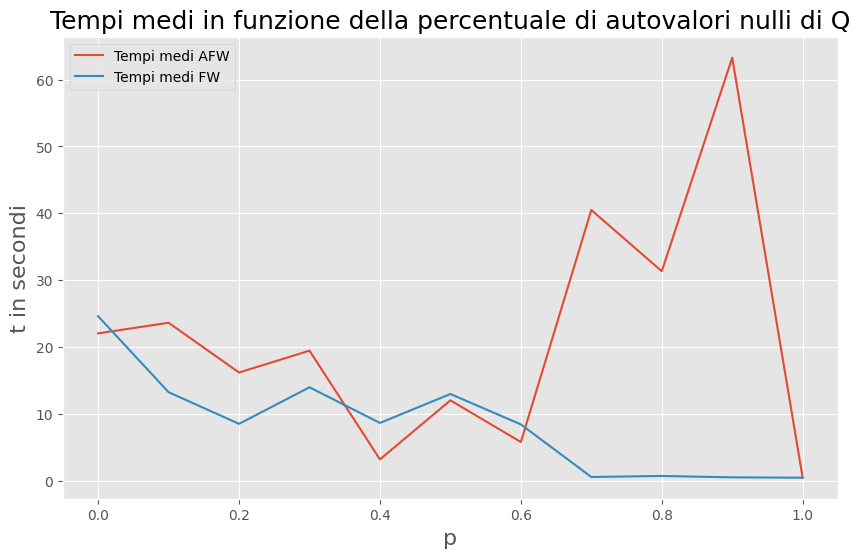

In [34]:
# PLOT 
plt.style.use('ggplot') 
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, 1, 11), tempi_afw, label='Tempi medi AFW')
plt.plot(np.linspace(0, 1, 11), tempi, label='Tempi medi FW')

plt.xlabel('p', fontsize = 16)
plt.ylabel('t in secondi', fontsize = 16)
plt.legend()
plt.title('Tempi medi in funzione della percentuale di autovalori nulli di Q', fontsize = 18)
#plt.ylim(-1, 40)   
plt.show()

#### Confronto FW e AFW su dual gap


In [32]:
# inizializzazione di x_0
x_0 = [random.randint(0, u_i) for u_i in u]

# np.save('x0.npy', x_0) # per fare gli esperimenti con  stessa x0
# x_0 = np.load('x0.npy') 

In [35]:
nome_file_dmx = '1000/netgen-1000-1-1-a-b-s.dmx'
_, numero_archi, u, _, q, _, _ , _ = leggi_file_dimacs(nome_file_dmx)
# Q = genera_Q(10, u, q, numero_archi, 0.8)
Q = genera_Q(1000, u, q, numero_archi, 0.2)
# Q = genera_Q(10, u, q, numero_archi, 0.0)
func = lambda x: np.dot(x, np.dot(Q, x))+np.dot(q,x)


gap, valori_f, k_totale, tempo_totale, tempi_per_it, x, sol_ottima, found_optimal = algoritmo_tradizionale(nome_file_dmx, epsilon = 0.0001, max_iter = 1000, Q = Q, q = q, u = u, numero_archi = numero_archi, tau = 0.01, step_size_ottimo = True, x_0 = x_0, visualize_res = False)
gap_afw, f_values_afw, k_afw, tempo_tot_afw, tempi_per_it_afw, x_afw, found_optimal_afw = AFW(nome_file_dmx, epsilon = 0.0001, max_iter = 1000, Q = Q, q = q, numero_archi = numero_archi, func=func, k_granularity=1, x_0 = x_0, visualize_res = False)

plot_dual_gap_bis(gap, gap_afw, p=10, alpha=0.2)